In [8]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier


1. Считать в `pandas.DataFrame` любой источник данных: CSV, JSON, Excel-файл, HTML-таблицу и т.п.

In [9]:
# Загрузка датасета
df = pd.read_csv("../dataset/Score.csv")

# Отображаем первые строки
df.head()

,Delay_from_due_date,Num_of_Delayed_Payment,Num_Credit_Inquiries,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Amount_invested_monthly,Monthly_Balance,Credit_Score,Credit_Mix,...,Age,Annual_Income,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Monthly_Inhand_Salary,Changed_Credit_Limit,Outstanding_Debt,Total_EMI_per_month
0,3.0,7.0,4.0,26.822620,265.0,No,80.415295,312.494089,Good,Good,...,23.0,19114.12,3.0,4.0,3.0,4.0,1824.843333,11.27,809.98,49.574949
1,3.0,7.0,4.0,31.944960,265.0,No,118.280222,284.629162,Good,Good,...,23.0,19114.12,3.0,4.0,3.0,4.0,1824.843333,11.27,809.98,49.574949
2,3.0,7.0,4.0,28.609352,267.0,No,81.699521,331.209863,Good,Good,...,23.0,19114.12,3.0,4.0,3.0,4.0,1824.843333,11.27,809.98,49.574949
3,5.0,4.0,4.0,31.377862,268.0,No,199.458074,223.451310,Good,Good,...,23.0,19114.12,3.0,4.0,3.0,4.0,1824.843333,11.27,809.98,49.574949
4,6.0,4.0,4.0,24.797347,269.0,No,41.420153,341.489231,Good,Good,...,23.0,19114.12,3.0,4.0,3.0,4.0,1824.843333,11.27,809.98,49.574949


2. Датасет и подготовка данных:
   - Привести описание датасета.
   - Осуществить предобработку данных (избавиться от `null`, убрать некоторые признаки и т.п.) - "подчистить данные".
   - Закодировать категориальные признаки при необходимости.
   - Нормализовать данные.
   - Разбить выборку на обучающую и тестовую.
     > Далее используем обучающую выборку, в том числе для метрик.

In [10]:
# Привести описание датасета
df.info()
df.describe(include='all')
df['Credit_Score'].value_counts()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99960 entries, 0 to 99959
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Delay_from_due_date       99960 non-null  float64
 1   Num_of_Delayed_Payment    99960 non-null  float64
 2   Num_Credit_Inquiries      99960 non-null  float64
 3   Credit_Utilization_Ratio  99960 non-null  float64
 4   Credit_History_Age        99960 non-null  float64
 5   Payment_of_Min_Amount     99960 non-null  object 
 6   Amount_invested_monthly   99960 non-null  float64
 7   Monthly_Balance           99960 non-null  float64
 8   Credit_Score              99960 non-null  object 
 9   Credit_Mix                99960 non-null  object 
 10  Payment_Behaviour         99960 non-null  object 
 11  Age                       99960 non-null  float64
 12  Annual_Income             99960 non-null  float64
 13  Num_Bank_Accounts         99960 non-null  float64
 14  Num_Cr

Credit_Score
Standard    53149
Poor        28988
Good        17823
Name: count, dtype: int64

In [11]:
# Осуществить предобработку данных (избавиться от `null`, убрать некоторые признаки и т.п.) - "подчистить данные".
df = df.dropna()

In [12]:
# Закодировать категориальные признаки при необходимости.
cat_cols = df.select_dtypes(include='object').columns.drop('Credit_Score')
df = pd.get_dummies(df, columns=cat_cols, drop_first=True)


df['Credit_Score'] = df['Credit_Score'].map({'Poor': 0, 'Standard': 1, 'Good': 2})

In [13]:
# Нормализовать данные.
num_cols = df.select_dtypes(include=['int64', 'float64']).columns.drop('Credit_Score')
scaler = MinMaxScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])

In [14]:
# Разбить выборку на обучающую и тестовую.
X = df.drop('Credit_Score', axis=1)
y = df['Credit_Score']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

3. Дерево решений:
   - С использованием `GridSearchCV` осуществить подбор гиперпараметра `DecisionTreeClassifier` (как минимум `max_depth`, `max_features`, другие параметры - по желанию.)
   - Вывести значения гиперпараметра и метрик для наилучшей модели `DecisionTreeClassifier` ($accuracy$, $precision$, $recall$, $\textit{f-measure}$).
   - Для полученного наилучшего дерева вывести `feature_importances`, отсортировать их по убыванию.
   - Осуществить фильтрацию признаков (по какому-нибудь значению порога важности признака).
   - Подобрать лучшую модель с использованием `GridSearchCV` на обучающей выборке с отфильтрованными признаками.
   - Вывести полученные гиперпараметры лучшей модели.
   - Сравнить метрики до и после фильтрации признаков лучших моделей.

In [15]:
param_grid = {
    'max_depth': range(3, 11),
    'max_features': ['sqrt', 'log2', None]
}

grid_tree = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid, cv=5, scoring='accuracy')
grid_tree.fit(X_train, y_train)

print("Best params:", grid_tree.best_params_)
print("Best score:", grid_tree.best_score_)

best_tree = grid_tree.best_estimator_

y_pred_tree = best_tree.predict(X_train)
print(classification_report(y_train, y_pred_tree))

Best params: {'max_depth': 10, 'max_features': None}
Best score: 0.7180872358804657
              precision    recall  f1-score   support

           0       0.78      0.69      0.73     23190
           1       0.77      0.77      0.77     42519
           2       0.60      0.71      0.65     14259

    accuracy                           0.74     79968
   macro avg       0.72      0.73      0.72     79968
weighted avg       0.74      0.74      0.74     79968



In [16]:
importances = pd.Series(best_tree.feature_importances_, index=X.columns)
importances_sorted = importances.sort_values(ascending=False)
print(importances_sorted)

selected_features = importances_sorted[importances_sorted > 0.02].index
X_train_filtered = X_train[selected_features]
X_test_filtered = X_test[selected_features]

Outstanding_Debt                                      0.327833
Credit_Mix_Standard                                   0.287029
Interest_Rate                                         0.087990
Delay_from_due_date                                   0.068481
Changed_Credit_Limit                                  0.054913
Num_Credit_Card                                       0.043076
Num_of_Delayed_Payment                                0.017799
Total_EMI_per_month                                   0.017457
Credit_History_Age                                    0.016206
Num_Bank_Accounts                                     0.012568
Num_Credit_Inquiries                                  0.011485
Annual_Income                                         0.010091
Age                                                   0.009413
Monthly_Inhand_Salary                                 0.009152
Amount_invested_monthly                               0.008806
Credit_Utilization_Ratio                              0

In [17]:
grid_tree_filtered = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid, cv=5, scoring='accuracy')
grid_tree_filtered.fit(X_train_filtered, y_train)

print("Filtered params:", grid_tree_filtered.best_params_)
print("Filtered score:", grid_tree_filtered.best_score_)

best_tree_filtered = grid_tree_filtered.best_estimator_
y_pred_tree_filtered = best_tree_filtered.predict(X_train_filtered)
print(classification_report(y_train, y_pred_tree_filtered))

Filtered params: {'max_depth': 10, 'max_features': None}
Filtered score: 0.7110344378891975
              precision    recall  f1-score   support

           0       0.72      0.73      0.72     23190
           1       0.77      0.75      0.76     42519
           2       0.60      0.62      0.61     14259

    accuracy                           0.72     79968
   macro avg       0.70      0.70      0.70     79968
weighted avg       0.72      0.72      0.72     79968



4. Случайный лес
   - Построить случайный лес (`RandomForestClassifier`), c использованием `GridSearchCV` осуществить подбор гиперпараметра.
   - Вывести полученные гиперпараметры лучшей модели случайного леса.
   - Осуществить фильтрацию признаков.
   - Подобрать лучшую модель с использованием `GridSearchCV` на обучающей выборке с отфильтрованными признаками.
   - Вывести полученные гиперпараметры лучшей модели случайного леса.
   - Сравнить метрики до и после фильтрации признаков лучших моделей.

In [19]:
param_grid_rf = {
    'n_estimators': [50, 100, 150],
    'max_depth': [5, 10, None],
    'max_features': ['sqrt', 'log2', None]
}

grid_rf = GridSearchCV(RandomForestClassifier(random_state=42), param_grid_rf, cv=5, scoring='accuracy', n_jobs=-1)
grid_rf.fit(X_train, y_train)

print("Best RF params:", grid_rf.best_params_)
print("Best RF score:", grid_rf.best_score_)

best_rf = grid_rf.best_estimator_

Best RF params: {'max_depth': None, 'max_features': None, 'n_estimators': 100}
Best RF score: 0.8040090699928811


In [20]:
rf_importances = pd.Series(best_rf.feature_importances_, index=X.columns).sort_values(ascending=False)
print(rf_importances)

selected_rf = rf_importances[rf_importances > 0.02].index
X_train_rf_filtered = X_train[selected_rf]
X_test_rf_filtered = X_test[selected_rf]

Outstanding_Debt                                      0.170569
Credit_Mix_Standard                                   0.115492
Credit_History_Age                                    0.079601
Credit_Utilization_Ratio                              0.064189
Amount_invested_monthly                               0.061020
Delay_from_due_date                                   0.060823
Changed_Credit_Limit                                  0.059891
Monthly_Balance                                       0.058375
Interest_Rate                                         0.054232
Num_of_Delayed_Payment                                0.038412
Total_EMI_per_month                                   0.036085
Age                                                   0.033559
Annual_Income                                         0.029521
Monthly_Inhand_Salary                                 0.029372
Num_Credit_Card                                       0.027528
Num_Credit_Inquiries                                  0

In [22]:
grid_rf_filtered = GridSearchCV(RandomForestClassifier(random_state=42), param_grid_rf, cv=5, scoring='accuracy', n_jobs=-1)
grid_rf_filtered.fit(X_train_rf_filtered, y_train)

print("Filtered RF params:", grid_rf_filtered.best_params_)
print("Filtered RF score:", grid_rf_filtered.best_score_)

Filtered RF params: {'max_depth': None, 'max_features': None, 'n_estimators': 100}
Filtered RF score: 0.8022333626782651


5. Метод ближайших соседей:
   - С использованием `GridSearchCV` осуществить подбор гиперпараметра `KNeighborsClassifier` (`n_neighbors`).
   - Вывести значения гиперпараметра и метрик для наилучшей модели.
   - Осуществить фильтрацию признаков.
   - Подобрать лучшую модель с использованием `GridSearchCV` на обучающей выборке с отфильтрованными признаками.
   - Вывести полученные гиперпараметры лучшей модели случайного леса.
   - Сравнить метрики до и после фильтрации признаков.

In [23]:
param_grid_knn = {'n_neighbors': list(range(3, 21))}

grid_knn = GridSearchCV(KNeighborsClassifier(), param_grid_knn, cv=5, scoring='accuracy', n_jobs=-1)
grid_knn.fit(X_train, y_train)

print("Best kNN params:", grid_knn.best_params_)
print("Best kNN score:", grid_knn.best_score_)

Best kNN params: {'n_neighbors': 3}
Best kNN score: 0.753688971293329


In [24]:
X_train_knn_filtered = X_train[selected_features]
X_test_knn_filtered = X_test[selected_features]

grid_knn_filtered = GridSearchCV(KNeighborsClassifier(), param_grid_knn, cv=5, scoring='accuracy', n_jobs=-1)
grid_knn_filtered.fit(X_train_knn_filtered, y_train)

print("Filtered kNN params:", grid_knn_filtered.best_params_)
print("Filtered kNN score:", grid_knn_filtered.best_score_)

Filtered kNN params: {'n_neighbors': 5}
Filtered kNN score: 0.7711084115744304


6. Если наблюдается улучшение метрик после фильтрации признаков хотя бы для одной из моделей, то для набора отфильтрованных признаков (пересечение множеств отфильтрованных признаков каждой модели или объединение множеств &ndash; не особо важно, главное описать, каким образом получен новый subset данных) заново построить наилучшие модели `KNeighborsClassifier`, `DecisionTreeClassifier`, `RandomForestClassifier`, сравнить модели в пункте 7 на одинаковом полученном наборе отфильтрованных признаков. Иначе &ndash; пропустить этот пункт.

In [25]:
common_features = set(selected_features).intersection(selected_rf)

X_train_common = X_train[list(common_features)]
X_test_common = X_test[list(common_features)]

# Обучение всех трёх моделей
dt_common = DecisionTreeClassifier(**grid_tree.best_params_, random_state=42).fit(X_train_common, y_train)
rf_common = RandomForestClassifier(**grid_rf.best_params_, random_state=42).fit(X_train_common, y_train)
knn_common = KNeighborsClassifier(**grid_knn.best_params_).fit(X_train_common, y_train)

7. Оценка качества построенных моделей:
   - Визуализировать любое полученное дерево решений.
     > Для вывода названий признаков в граф необходимо задать значение аргумента `feature_names` в `sklearn.tree.export_graphviz`, для вывода названий классов &ndash; `class_names` (перед кодированием целевого признака можно сохранить названия в отдельный массив).
   - Сравнить лучшие модели `KNeighborsClassifier`, `DecisionTreeClassifier`, `RandomForestClassifier` на **тестовой выборке**. Привести значения метрик $accuracy$, $precision$, $recall$, $\textit{f-measure}$.

=== Decision Tree ===
Accuracy: 0.7146358543417367
Precision: 0.6879572933869386
Recall: 0.692232337348865
F1-score: 0.6900317235858626
              precision    recall  f1-score   support

           0       0.71      0.71      0.71      5798
           1       0.76      0.75      0.75     10630
           2       0.60      0.61      0.61      3564

    accuracy                           0.71     19992
   macro avg       0.69      0.69      0.69     19992
weighted avg       0.72      0.71      0.72     19992




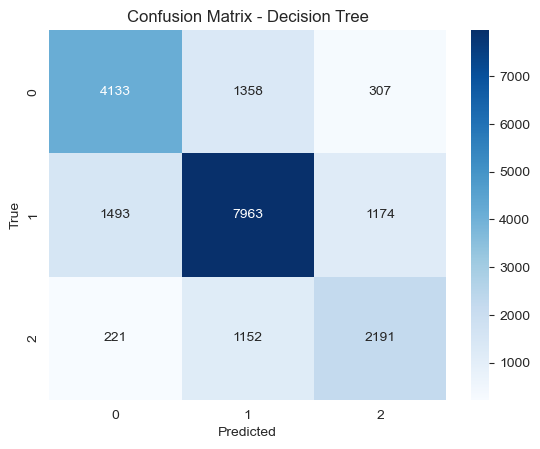

=== Random Forest ===
Accuracy: 0.7901160464185675
Precision: 0.7777265487860495
Recall: 0.7870730358576049
F1-score: 0.7821493229633253
              precision    recall  f1-score   support

           0       0.78      0.81      0.80      5798
           1       0.81      0.79      0.80     10630
           2       0.74      0.76      0.75      3564

    accuracy                           0.79     19992
   macro avg       0.78      0.79      0.78     19992
weighted avg       0.79      0.79      0.79     19992




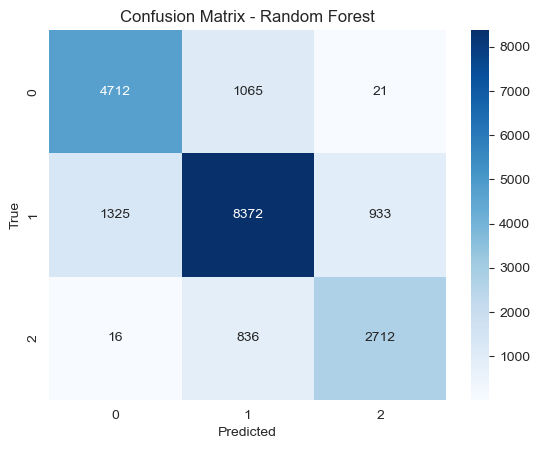

=== kNN ===
Accuracy: 0.7769607843137255
Precision: 0.7613321199543869
Recall: 0.7711859059037162
F1-score: 0.765983293660081
              precision    recall  f1-score   support

           0       0.77      0.80      0.78      5798
           1       0.81      0.78      0.79     10630
           2       0.71      0.74      0.72      3564

    accuracy                           0.78     19992
   macro avg       0.76      0.77      0.77     19992
weighted avg       0.78      0.78      0.78     19992




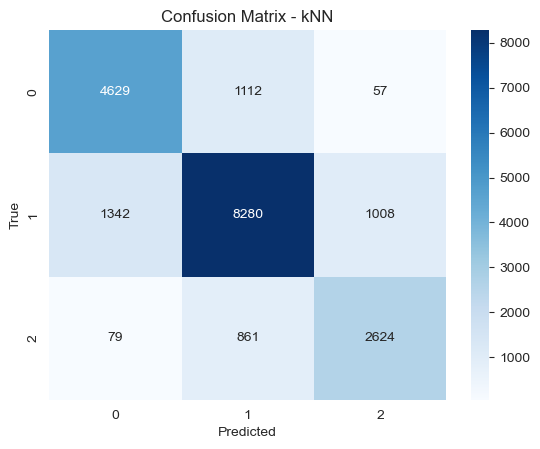

In [26]:
models = {
    "Decision Tree": dt_common,
    "Random Forest": rf_common,
    "kNN": knn_common
}

for name, model in models.items():
    y_pred = model.predict(X_test_common)
    print(f"=== {name} ===")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Precision:", precision_score(y_test, y_pred, average='macro'))
    print("Recall:", recall_score(y_test, y_pred, average='macro'))
    print("F1-score:", f1_score(y_test, y_pred, average='macro'))
    print(classification_report(y_test, y_pred))
    print()

    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {name}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

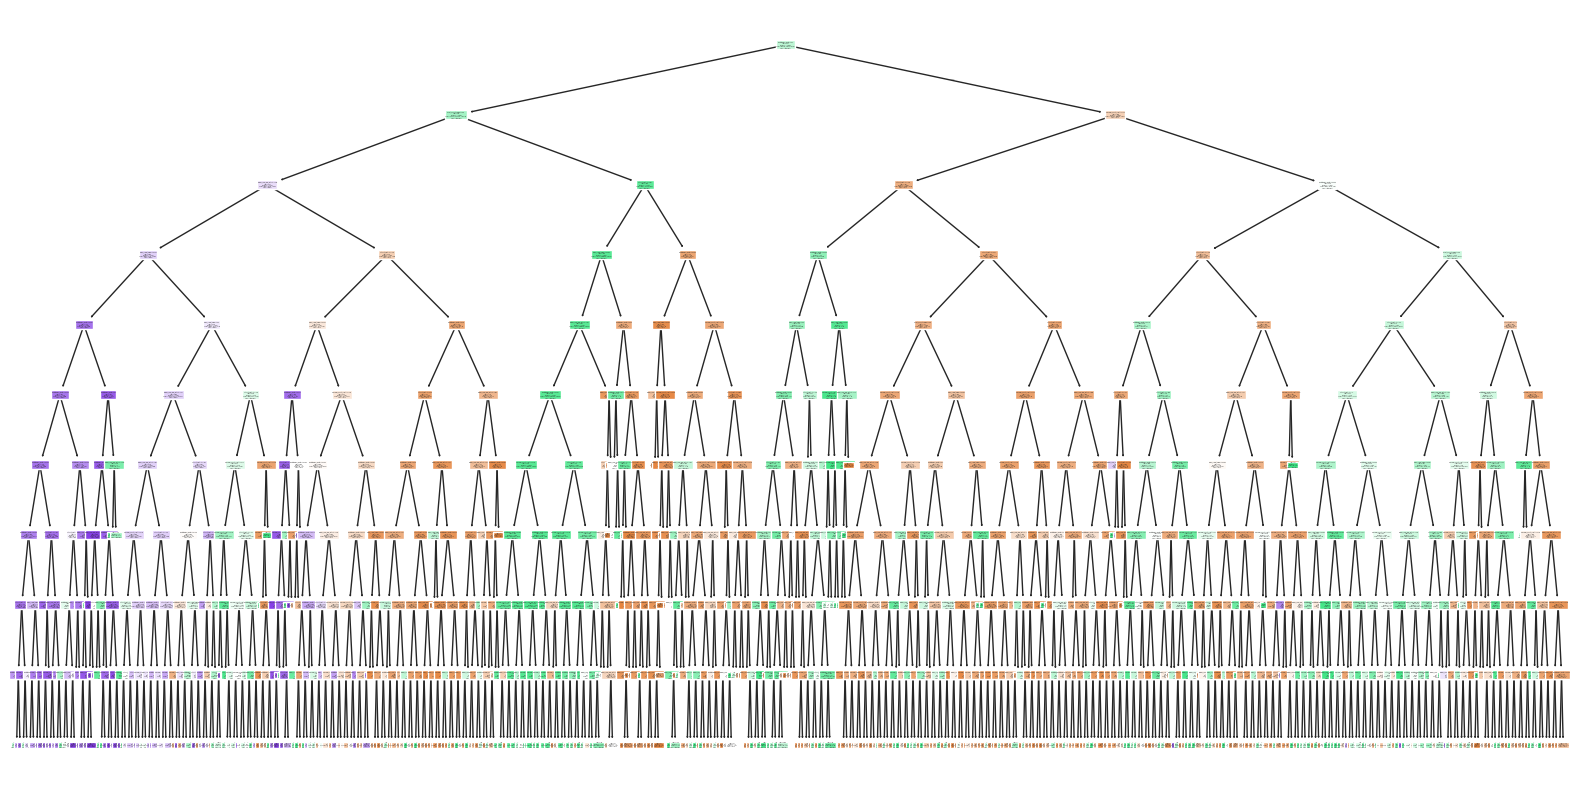

In [27]:
plt.figure(figsize=(20,10))
plot_tree(dt_common, feature_names=X_train_common.columns, class_names=['Poor', 'Standard', 'Good'], filled=True)
plt.show()

### Выводы

- Decision Tree показало наименьшую точность из всех трех моделей.
- Random Forest показал лучшую точность по всем метрикам.
- kNN показал точность очень близкую к RandomForest, но затратил на это меньше ресурсов,<br/>
что делает данный вариант оптимальным для решения поставленной задачи.